In [1]:
import torch
import torch.nn as nn
from cell import utils, plot_utils, analysis
from cell.Word2vec import prepare_vocab, dataloader, wv
import os
import numpy as np
import time

os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
import imp
from cell import  utils


imp.reload(utils)
imp.reload(plot_utils)

<module 'cell.plot_utils' from '/Users/fahimehb/Documents/git-workspace/celltypes/cell/plot_utils.py'>

In [3]:
length = 10000
p = 1
q = 1
N = 1
batch_size = 2000
walk_filename = "walk_0.csv"
roi = "VISp"
project_name = "NPP_GNN_project"
layer_class = "single_layer"
layer = "base_unnormalized_allcombined"
walk_type= "Directed_Weighted_node2vec"

#walk_dir = utils.get_walk_dir(roi, project_name, N, length, p, q, layer_class, layer, walk_type) 

In [4]:
walk_dir

'//Users/fahimehb/Documents/NPP_GNN_project/dat/walks/VISp/single_layer/Directed_Weighted_node2vec/N_1_l_10000_p_1_q_1/base_unnormalized_allcombined'

### Prepare vocab

In [4]:
corpus = utils.read_list_of_lists_from_csv(walk_dir, walk_filename)
# corpus = corpus[:-1]
vocabulary = prepare_vocab.get_vocabulary(corpus)

print(f'lenght of vocabulary: {len(vocabulary)}')

word_2_index = prepare_vocab.get_word2idx(vocabulary)
index_2_word = prepare_vocab.get_idx2word(vocabulary)

lenght of vocabulary: 93


In [5]:
context_tuple_list = prepare_vocab.get_word_context_tuples(corpus, window=2)

There are 2789628 pairs of target and context words


### Dataloader

In [6]:
dataset = dataloader.WalkDataset(context_tuple_list, 
                                 word_2_index)

data_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                          batch_size=2000, 
                                          shuffle=True,
                                          num_workers=1)

In [7]:
# examples = iter(data_loader)
# samples, labels = examples.next()
# print(samples.shape, labels.shape)

In [8]:
# len(data_loader)

In [9]:
# context_tuple_batches[0][0] == samples

### Train the model

In [6]:
#vocab_size = len(vocabulary)
embedding_size = 2
learning_rate = 0.001
n_epochs = 20

In [31]:
criterion = nn.CrossEntropyLoss()

model = wv.Word2Vec(embedding_size=embedding_size, vocab_size=vocab_size)

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
n_total_steps = len(data_loader)

training_loss = []


for epoch in range(n_epochs):
    t0 = time.time()
    losses = []
    for i, (target, context) in enumerate(data_loader):
        target = target.to(device)
        context = context.to(device)
        prediction = model(context)
        loss = criterion(prediction, target)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    t1 = time.time()
    print('time is %.2f' % (t1 - t0))
        
    training_loss.append(np.mean(losses)) 
    print(f'epoch: {epoch+1}/{n_epochs}, loss:{np.mean(losses):.4f}')

KeyboardInterrupt: 

In [12]:
print("Done!")

Done!


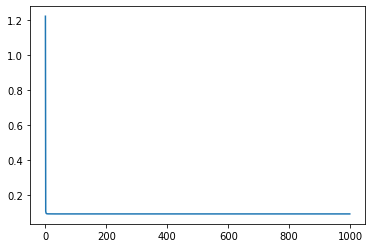

In [13]:
plt.plot(training_loss)

Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


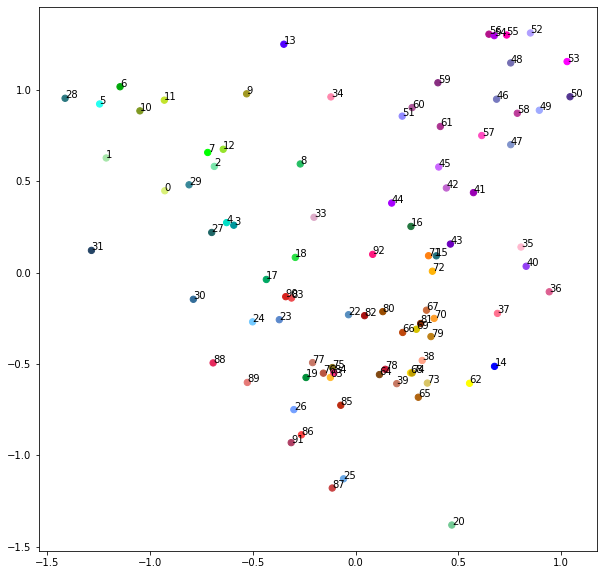

In [42]:
cldf = utils.read_visp_npp_cldf()

vectors = pd.read_csv("/Users/fahimehb/Documents/NPP_GNN_project/models/VISp/single_layer/\
Directed_Weighted_node2vec/N_1_l_10000_p_1_q_1/base_unnormalized_allcombined/model_size_2_iter_100_window_2_lr_0.001_bs_2000.csv")

vectors["cluster_id"] = vectors["cluster_id"].astype(str)
vectors = vectors.set_index("cluster_id")
vectors.index  
vectors = vectors.merge(cldf, on="cluster_id")
fig = plot_utils.plot_embedding(data=vectors, 
                          plot_dim=2,
                          plot_size=(10,10),
                          annotation = True)

In [45]:
cldf.loc[[ '16', "77"]]

,dendcluster_id,cluster_label,colors,cluster_color,subclass_id,subclass_label,subclass_color,class_id,class_label,class_color
cluster_id,,,,,,,,,,
16,31,L5 PT VISp C1ql2 Ptgfr,#247740,#247740,11,L5 PT,#0D5B78,2,Glutamatergic,#27AAE1
77,100,Sst Crh 4930553C11Rik,#C77767,#C77767,5,Sst,#F15A29,1,GABAergic,#EF4136


In [31]:
fig.savefig("/Users/fahimehb/Documents/GNN/dat/jsd_results/gnn_91nodes.png", dpi=750)

In [29]:
%matplotlib qt5
from cell import analysis, plot_utils
cldf = utils.read_visp_npp_cldf()
vectors = model.embeddings.weight.detach().numpy()
data = analysis.summarize_walk_embedding_results(gensim_dict={"model": vectors},
                                                 index = index_2_word.values(),
                                                 ndim=3, 
                                                 cl_df=cldf)

plot_utils.plot_embedding(data=data, 
                          cl_df=cldf,
                          plot_dim=3, 
                          plot_size=(5,5), 
                          annotation=False)

Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


In [16]:
model_dir = utils.get_model_dir(project_name, roi, N, length, p, q, layer_class, layer, walk_type)

In [23]:
batch_size = 2000
model_name = utils.get_model_name(embedding_size, n_epochs, 2, learning_rate, batch_size)

In [24]:
model_name

'model_size_3_iter_1000_window_2_lr_0.001_bs_2000.csv'

In [26]:
loss_name = utils.get_loss_filename(embedding_size, n_epochs, 2, learning_rate, batch_size)

In [27]:
data.to_csv(os.path.join(model_dir, model_name))

In [28]:
utils.write_list_to_csv(model_dir, loss_name, training_loss)

Done writing!


Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


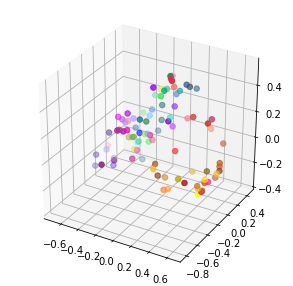

In [21]:
from cell import analysis, plot_utils
cldf = utils.read_visp_npp_cldf()
vectors = model.embeddings.weight.detach().numpy()
data = analysis.summarize_walk_embedding_results(gensim_dict={"model": vectors},
                                                 index = index_2_word.values(),
                                                 ndim=3, 
                                                 cl_df=cldf)

plot_utils.plot_embedding(data=data, cl_df=cldf, plot_dim=3, plot_size=(5,5))

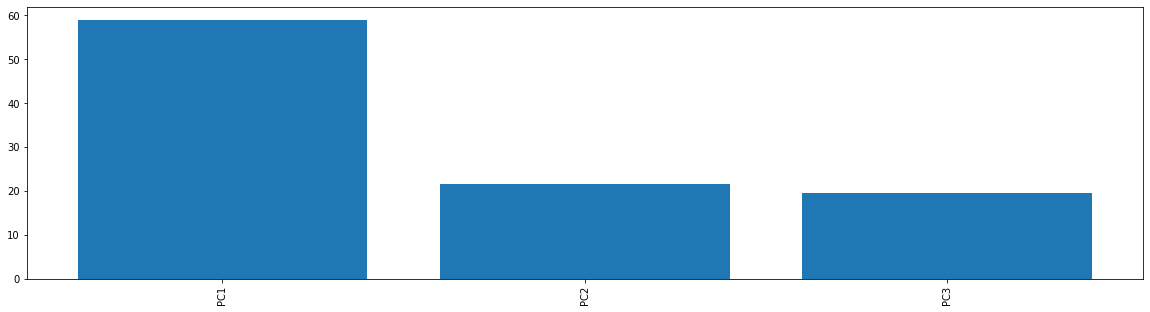

In [22]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
vectors = model.embeddings.weight.detach().numpy()
#scaled_data = preprocessing.StandardScaler().fit_transform(vectors)

pca = PCA(n_components=3)
pca.fit(vectors)
pca_data = pca.transform(vectors)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.figure(figsize=(20,5))
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label= labels)
plt.xticks(rotation = 90)
plt.show()

# From here after is for if you want to add negative sampling

In [45]:
from numpy.random import multinomial

def sample_negative(sample_size):
    sample_probability = {}
    word_counts = dict(Counter(list(itertools.chain.from_iterable(corpus))))
    normalizing_factor = sum([v**0.75 for v in word_counts.values()])
    for word in word_counts:
        sample_probability[word] = word_counts[word]**0.75 / normalizing_factor
    words = np.array(list(word_counts.keys()))
    while True:
        word_list = []
        sampled_index = np.array(multinomial(sample_size, list(sample_probability.values())))
        for index, count in enumerate(sampled_index):
            for _ in range(count):
                 word_list.append(words[index])
        yield word_list

In [46]:
import random

def get_batches(context_tuple_list, batch_size=100):
    random.shuffle(context_tuple_list)
    batches = []
    batch_target, batch_context, batch_negative = [], [], []
    for i in range(len(context_tuple_list)):
        batch_target.append(word_to_index[context_tuple_list[i][0]])
        batch_context.append(word_to_index[context_tuple_list[i][1]])
        batch_negative.append([word_to_index[w] for w in context_tuple_list[i][2]])
        if (i+1) % batch_size == 0 or i == len(context_tuple_list)-1:
            tensor_target = autograd.Variable(torch.from_numpy(np.array(batch_target)).long())
            tensor_context = autograd.Variable(torch.from_numpy(np.array(batch_context)).long())
            tensor_negative = autograd.Variable(torch.from_numpy(np.array(batch_negative)).long())
            batches.append((tensor_target, tensor_context, tensor_negative))
            batch_target, batch_context, batch_negative = [], [], []
    return batches

In [47]:
import numpy as np

context_tuple_list = []
w = 2
negative_samples = sample_negative(5)

k =0 
for text in corpus:
    print(len(text))
    for i, word in enumerate(text):
        first_context_word_index = max(0,i-w)
        last_context_word_index = min(i+w, len(text))
        for j in range(first_context_word_index, last_context_word_index):
            if i!=j:
                context_tuple_list.append((word, text[j], next(negative_samples)))
print("There are {} pairs of target and context words".format(len(context_tuple_list)))

10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
There are 2789628 pairs of target and context words


In [63]:
context_tuple_list[0:10]

[('23', '67', ['72', '2', '84', '3', '70']),
 ('8', '23', ['45', '69', '31', '91', '90']),
 ('21', '77', ['82', '79', '31', '11', '49']),
 ('32', '23', ['28', '21', '67', '64', '12']),
 ('75', '25', ['22', '80', '87', '47', '55']),
 ('49', '75', ['62', '58', '70', '55', '12']),
 ('9', '71', ['54', '50', '58', '90', '23']),
 ('60', '75', ['28', '72', '80', '84', '59']),
 ('46', '37', ['74', '79', '63', '91', '35']),
 ('69', '60', ['2', '78', '76', '71', '12'])]

In [50]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F


class Word2Vec(nn.Module):

    def __init__(self, embedding_size, vocab_size):
        super(Word2Vec, self).__init__()
        self.embeddings_target = nn.Embedding(vocab_size, embedding_size)
        self.embeddings_context = nn.Embedding(vocab_size, embedding_size)

    def forward(self, target_word, context_word, negative_example):
        emb_target = self.embeddings_target(target_word)
        emb_context = self.embeddings_context(context_word)
        emb_product = torch.mul(emb_target, emb_context)
        emb_product = torch.sum(emb_product, dim=1)
        out = torch.sum(F.logsigmoid(emb_product))
        emb_negative = self.embeddings_context(negative_example)
        emb_product = torch.bmm(emb_negative, emb_target.unsqueeze(2))
        emb_product = torch.sum(emb_product, dim=1)
        out += torch.sum(F.logsigmoid(-emb_product))
        return -out

In [51]:
import time

vocabulary_size = len(vocabulary)

loss_function = nn.CrossEntropyLoss()
net = Word2Vec(embedding_size=2, vocab_size=vocabulary_size)
optimizer = optim.Adam(net.parameters())

training_loss = []
for epoch in range(100):
    losses = []
    context_tuple_batches = get_batches(context_tuple_list, batch_size=2000)
    for i in range(len(context_tuple_batches)):
        net.zero_grad()
        target_tensor, context_tensor, negative_tensor = context_tuple_batches[i]
        loss = net(target_tensor, context_tensor, negative_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.data)
    print("Loss: ", np.mean(losses))
    training_loss.append(np.mean(losses))

Loss:  3136.882
Loss:  2152.383
Loss:  2084.9182
Loss:  2077.8765
Loss:  2072.071
Loss:  2069.3745
Loss:  2069.0632
Loss:  2069.039
Loss:  2069.0354
Loss:  2069.0442
Loss:  2069.0369
Loss:  2069.0417
Loss:  2069.0388
Loss:  2069.0413
Loss:  2069.0398
Loss:  2069.0425
Loss:  2069.036
Loss:  2069.0366
Loss:  2069.0405
Loss:  2069.043
Loss:  2069.0347
Loss:  2069.0388
Loss:  2069.0405
Loss:  2069.0383
Loss:  2069.0327
Loss:  2069.042
Loss:  2069.04
Loss:  2069.0415
Loss:  2069.041
Loss:  2069.0388
Loss:  2069.034
Loss:  2069.0408
Loss:  2069.0378
Loss:  2069.0369
Loss:  2069.0435
Loss:  2069.037
Loss:  2069.0347
Loss:  2069.0376
Loss:  2069.036
Loss:  2069.0405
Loss:  2069.0388
Loss:  2069.0366
Loss:  2069.0378
Loss:  2069.0369
Loss:  2069.0312
Loss:  2069.034
Loss:  2069.038
Loss:  2069.0361
Loss:  2069.04
Loss:  2069.037
Loss:  2069.034
Loss:  2069.035
Loss:  2069.0352
Loss:  2069.0352
Loss:  2069.0322
Loss:  2069.032
Loss:  2069.0383
Loss:  2069.0383
Loss:  2069.0366
Loss:  2069.039
Lo

(2000, 2200)

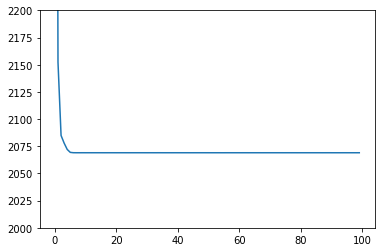

In [70]:
plt.plot(training_loss)
plt.ylim(2000,2200)

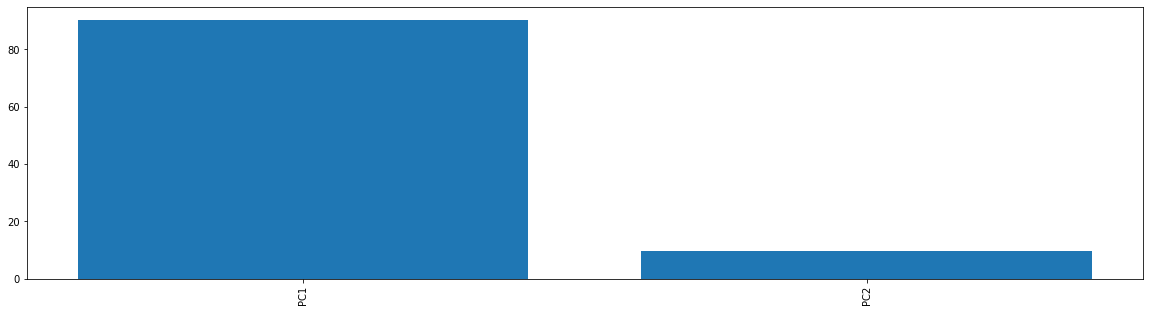

In [60]:
vectors = net.embeddings_context.weight.detach().numpy()
pca = PCA(n_components=2)
pca.fit(vectors)
pca_data = pca.transform(vectors)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.figure(figsize=(20,5))
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label= labels)
plt.xticks(rotation = 90)
plt.show()

Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


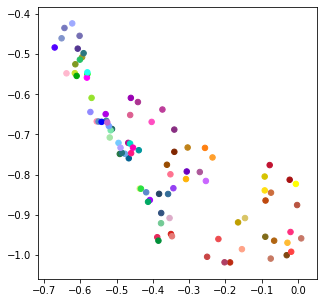

In [66]:
vectors = net.embeddings_context.weight.detach().numpy()

cldf = utils.read_visp_npp_cldf()

data = analysis.summarize_walk_embedding_results(gensim_dict={"model": vectors},
                                                 index = index_to_word.values(),
                                                 ndim=2, 
                                                 cl_df=cldf)

plot_utils.plot_embedding(data=data, cl_df=cldf, plot_dim=2, plot_size=(5,5))

Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


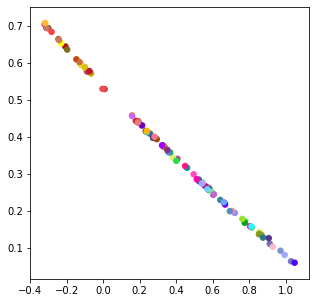

In [67]:
vectors = net.embeddings_target.weight.detach().numpy()

cldf = utils.read_visp_npp_cldf()

data = analysis.summarize_walk_embedding_results(gensim_dict={"model": vectors},
                                                 index = index_to_word.values(),
                                                 ndim=2, 
                                                 cl_df=cldf)

plot_utils.plot_embedding(data=data, cl_df=cldf, plot_dim=2, plot_size=(5,5))

In [66]:
import numpy as np

def get_closest_word(word, topn=5):
    word_distance = []
    emb = net.embeddings_target
    pdist = nn.PairwiseDistance()
    i = word_to_index[word]
    lookup_tensor_i = torch.tensor([i], dtype=torch.long)
    v_i = emb(lookup_tensor_i)
    for j in range(len(vocabulary)):
        if j != i:
            lookup_tensor_j = torch.tensor([j], dtype=torch.long)
            v_j = emb(lookup_tensor_j)
            word_distance.append((index_to_word[j], float(pdist(v_i, v_j))))
    word_distance.sort(key=lambda x: x[1])
    return word_distance[:topn]